# MVA - Homework 2 - Reinforcement Learning (2021/2022)

**Name:** BRUTTI Rafaël

**Email:**    rafael.brutti@telecom-paris.fr

## Instructions

* The deadline is **December 10 (2021) at 11:59 pm (Paris time).**

* By doing this homework you agree to the late day policy, collaboration and misconduct rules reported on [Piazza](https://piazza.com/class/ktmvsc4knke4ia?cid=6).

* **Mysterious or unsupported answers will not receive full credit**. A correct answer, unsupported by calculations, explanation, or algebraic work will receive no credit; an incorrect answer supported by substantially correct calculations and explanations might still receive partial credit.

* Answers should be provided in **English**.

# Colab setup

In [ ]:
from IPython import get_ipython

if 'google.colab' in str(get_ipython()):
  # install rlberry library
  !pip install git+https://github.com/rlberry-py/rlberry.git@mva2021#egg=rlberry[default] > /dev/null 2>&1

  # pytorch
  !pip install torch > /dev/null 2>&1

  # install ffmpeg-python for saving videos
  !pip install ffmpeg-python > /dev/null 2>&1

  # packages required to show video
  !pip install pyvirtualdisplay > /dev/null 2>&1
  !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

  print("Libraries installed, please restart the runtime!")


Libraries installed, please restart the runtime!


In [ ]:
# Create directory for saving videos
!mkdir videos > /dev/null 2>&1

# Initialize display and import function to show videos
import rlberry.colab_utils.display_setup
from rlberry.colab_utils.display_setup import show_video

In [ ]:
# Useful imports
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from gym.wrappers import Monitor
from rlberry.agents import Agent
from rlberry.manager import AgentManager, plot_writer_data

import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

# torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

[INFO] OpenGL_accelerate module loaded 
[INFO] Using accelerated ArrayDatatype 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt 


# Preparation

## Environment
In the coding exercises, you will use the CartPole environment from [Gym](https://gym.openai.com/) library. The cells below show how to interact with this MDP and how to visualize it.

In [ ]:
def get_env():
  """Creates an instance of a CartPole-v0 environment."""
  return gym.make('CartPole-v0')

def render_policy(env, agent):
  env = deepcopy(env)
  env = Monitor(env, './videos', force=True, video_callable=lambda episode: True)
  for episode in range(1):
    done = False
    state = env.reset()
    env.render()
    while not done:
        action = agent.select_action(state, evaluation=True)
        state, reward, done, info = env.step(action)
        env.render()
    env.close()
    show_video()

## Running experiments with `rlberry`
In order to compare different algorithms, you'll need to run experiments several times and plot the results. For that, we use the [rlberry](https://github.com/rlberry-py/rlberry) library here.
The code below gives a quick introduction to what you will need from this library, but you can also check its documentation [here](https://rlberry.readthedocs.io/en/latest/).

Basically, all you have to do is to write your agents using the `rlberry.agents.Agent` interface, and `rlberry` provides an `AgentManger` class that allows you to run your agents in parallel and plot the results.

In [ ]:
from rlberry.agents import Agent

class MyAgent(Agent):
  name = "MyAgent"
  def __init__(self, env, param1, param2, **kwargs):
    """
    The base class (Agent) initializes:
      self.env : instance of the environment used for training (in fit() method)
      self.eval_env : instance of the environment used for evaluation (in eval() method)
      self.rng : random number generator (https://numpy.org/doc/stable/reference/random/generator.html)
      self.writer : use self.writer.add_scalar(tag, value, global_step) to log training data
    
    For reproducibility, use ONLY self.rng if you need random numbers in you agent!
    To be able to visualize plots with AgentManager, log data using self.writer (see below)
    """
    Agent.__init__(self, env, **kwargs)
    self.param1 = param1
    self.param2 = param2
    self.total_steps = 0
    self.total_episodes = 0

  def select_action(self, state, evaluation=False):
    """
    If evaluation=True, run evaluation policy (e.g., greedy with respect to Q)
    If evaluation=False, run exploration policy (e.g., epsilon greedy)
    """
    return self.env.action_space.sample()  # random action for this example

  def fit(self, budget):
    """budget = number of timesteps to train your agent"""
    state = self.env.reset()
    episode_reward = 0.0
    for tt in range(budget):
      self.total_steps += 1
      action = self.select_action(state, evaluation=False)
      next_state, reward, done, _ = self.env.step(action)
      episode_reward += reward

      # Log data
      self.writer.add_scalar('rewards', reward, global_step=self.total_steps)

      state = next_state 
      if done:
        self.total_episodes += 1
        # Log episode data
        self.writer.add_scalar('episode_rewards', episode_reward, global_step=self.total_steps)
        self.writer.add_scalar('episode', self.total_episodes, global_step=self.total_steps)

        state = self.env.reset()
        episode_reward = 0.0
        
  
  def eval(self, **kwargs):
    """
    Here, you can run Monte-Carlo policy evaluation 
    with self.eval_env and return the result.
    Returning zero for this example.
    """
    return 0.0

In [ ]:
#
# Initialize and train a single instance of MyAgent
#
my_agent = MyAgent(
    env=(get_env, {}),       # tuple (constructor, kwargs)
    param1=10,               # extra params your agent might need
    param2=15)
# train the agent for 100 timesteps
my_agent.fit(100)
# pandas DataFrame containing data stored with my_agent.writer.add_scalar(tag, value, global_step)
print(my_agent.writer.data)

#
# Run several instances of MyAgent in parallel and plot the results
#
manager_kwargs = dict(
    agent_class=MyAgent,
    train_env=(get_env, dict()),
    eval_env=(get_env, dict()),
    fit_budget=100,                    # Number of total timesteps
    n_fit=2,                           # Number of agent instances to fit
    parallelization='thread',          # Use 'thread' in the notebook!
    seed=456,                          # Seed
    default_writer_kwargs=dict(maxlen=None,log_interval=10),
)
my_agent_manager = AgentManager(
    init_kwargs=dict(param1=10, param2=20),
    agent_name='MyAgent',
    **manager_kwargs
)
my_agent_manager.fit()   # Train 'n_fit' instances in parallel

[WARNING] (Re)defining the following DefaultWriter parameters in AgentManager: ['maxlen', 'log_interval'] 
[INFO] Running AgentManager fit() for MyAgent...  


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
        name              tag      value global_step
0    MyAgent          rewards   1.000000           1
1    MyAgent          rewards   1.000000           2
2    MyAgent          rewards   1.000000           3
3    MyAgent          rewards   1.000000           4
4    MyAgent          rewards   1.000000           5
..       ...              ...        ...         ...
203  MyAgent  dw_time_elapsed   0.002738         100
204  MyAgent  episode_rewards  32.000000          32
205  MyAgent  episode_rewards  57.000000          89
206  MyAgent          episode   1.000000          32
207  MyAgent          episode   2.000000          89

[208 rows x 4 columns]
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] ... trained! 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] NumExpr defaulting to 2 threads. 


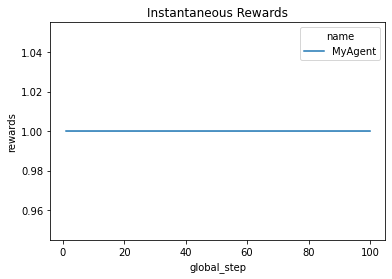

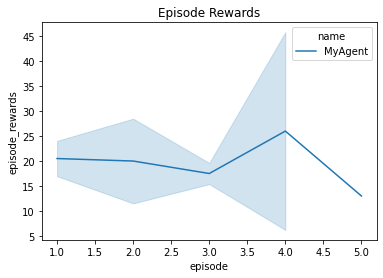

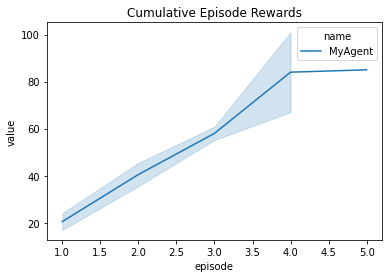

INFO: Clearing 4 monitor files from previous run (because force=True was provided)
INFO: Starting new video recorder writing to /content/videos/openaigym.video.0.1948.video000000.mp4
INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/videos')


In [ ]:
# Plot the results
example_managers = []
example_managers.append(my_agent_manager)    # You could add more managers here, for other agents/parameters
_ = plot_writer_data(example_managers, tag='rewards', title='Instantaneous Rewards')
_ = plot_writer_data(example_managers, tag='episode_rewards', xtag='episode', title='Episode Rewards')
_ = plot_writer_data(example_managers, tag='episode_rewards', xtag='episode', title='Cumulative Episode Rewards', preprocess_func=np.cumsum)

# Render the policy of one of the trained agents
agent_instance = my_agent_manager.get_agent_instances()[0]
render_policy(agent_instance.eval_env, agent_instance)

# Part 1: DQN

The goal of this exercise is to compare different variants of Deep Q-Learning (a.k.a. DQN).

**DQN.**
Recall from the class the DQN aims to minimize the following loss function
$$
    L(\theta) = \mathbb{E}_{s,a,r,s' \sim \mathcal{D}} \left[
\left(
    r + \gamma \max_{a' \in\mathcal{A}} Q(s',a';\theta') - Q(s,a; \theta)
\right)^2
    \right ]
$$
where $\theta'$ is the parameter of the target network updated every $C$ iterations from $\theta$.



## Question 1.1 (written)

**(a)** The DQN objective resembles a classical supervised learning problem. Could you highlight the differences?

**(b)** Could you describe the role of $C$ and the trade-off at play in choosing a good value for $C$?

**answer**

(a) The target function is $r + \gamma \max_{a' \in\mathcal{A}} Q(s',a';\theta')$. The main difference with a classical supervised learning problem is that the target function changes every C iterations due to the update of the target network. Moreover, the dataset comes from the replay buffer and therefore depends on what the algorithm have explored and learned whereas in a classical supervised learning problem the dataset is fixed. 

(b) C is the number of iterations performed on the predicted network leading to new weights before updating the target network with these weights. Its role is to improve stability. 

If C is large: many iterations are performed before updating the target network, which leads to better convergence of the network to the current target network and thus better stability, but this will focus too long on training an outdated target.

If C is close to 1 : the target network is often updated and then is no longer outdated. However, the prediction will be less accurate and there will be less stability in the convergence.

## Question 2.2 (implementation)

We would like to evaluate DQN with newer variants of DQN, namely Double DQN, Dueling DQN and Double Dueling DQN.
In class we have seen the principle of DQN, please refer to the following paper for Double and Dueling DQN (https://arxiv.org/abs/1511.06581).



The difference between DQN and Double DNQ is how the target network is built. In Double DQN we use the greedy action suggested by $Q(s,a; \boldsymbol{\theta})$ to evaluate the target (i.e., $\theta'$), see the appendix of https://arxiv.org/abs/1511.06581.

In Dueling DQN, the Q function is estimated as
$$
    Q(s,a) = V(s) + A(s,a) - \frac{1}{|\mathcal{A}|} \sum_{a'} A(s,a')
$$
$V$ and $A$ share parameters.
Dueling DQN can be implemented "standard" or "double".


Starting from the provided code:
- (code) Implement DQN and Double DQN. Use the network in the figure below **(top)**.
- (code) Implement Dueling DQN and Dueling Double DQN. See the figure below **(bottom)** for the network with shared parameters.
- Compare the performance of the algorithms.


More precisely, you'll have to:
* complete the code for the networks `QNet` and `DuelingQNet`;
* compute the loss in the fit() method of `DQNAgent`
* define the exploration and evaluation policy in the `select_action` method of `DQNAgent`

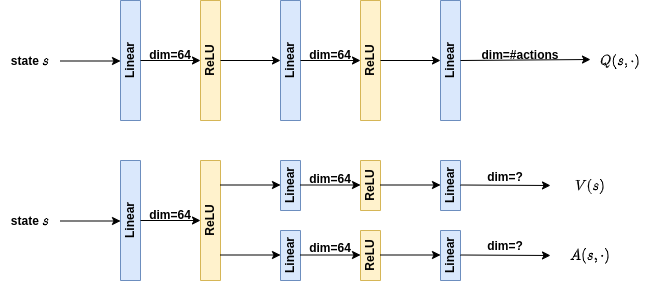

In [ ]:
class ReplayBuffer:
  def __init__(self, capacity, rng):
    """
    Parameters
    ----------
    capacity : int
      Maximum number of transitions
    rng : 
      instance of numpy's default_rng
    """
    self.capacity = capacity
    self.rng = rng  # random number generator
    self.memory = []
    self.position = 0

  def push(self, sample):
    """Saves a transition."""
    if len(self.memory) < self.capacity:
      self.memory.append(None)
    self.memory[self.position] = sample
    self.position = (self.position + 1) % self.capacity

  def sample(self, batch_size):
    indices = self.rng.choice(len(self.memory), size=batch_size)
    samples = [self.memory[idx] for idx in indices]
    return map(np.asarray, zip(*samples))

  def __len__(self):
    return len(self.memory)

In [ ]:
class QNet(nn.Module):
  def __init__(self, obs_size, n_actions):
    super(QNet, self).__init__()
    self.fc1 = nn.Linear(obs_size, 64)
    self.ReLU = nn.ReLU()
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, n_actions)

  def forward(self, state):
    Q = self.ReLU(self.fc1(state))
    Q = self.ReLU(self.fc2(Q))
    Q = self.fc3(Q)
    return Q


class DuelingQNet(nn.Module):
  def __init__(self, obs_size, n_actions):
    super(DuelingQNet, self).__init__()
    self.fc1 = nn.Linear(obs_size, 64)
    self.relu = nn.ReLU()
    self.fc2A = nn.Linear(64, 64)
    self.fc3A = nn.Linear(64, n_actions)
    self.fc2V = nn.Linear(64, 64)
    self.fc3V = nn.Linear(64, 1)

  def forward(self, state):
    Q = self.relu(self.fc1(state))

    # Compute A
    A = self.relu(self.fc2A(Q))
    A = self.fc3A(A)

    # Compute V
    V = self.relu(self.fc2V(Q))
    V = self.fc3V(V)
    Q = V + A - A.mean()
    return Q


In [ ]:
# Parameters
DQN_TRAINING_TIMESTEPS = 10000  # number of timesteps for training. You might change this!

DQN_PARAMS = dict(
    dueling_dqn=False,         # set to true to use dueling DQN
    double_dqn=False,          # set to true to use double DQN
    gamma=0.99,
    batch_size=256,            # batch size (in number of transitions)
    eval_every=250,            # evaluate every ... steps
    buffer_capacity=30000,     # capacity of the replay buffer
    update_target_every=500,   # update target net every ... steps
    epsilon_start=1.0,         # initial value of epsilon
    epsilon_min=0.05,          # minimum value of epsilon
    decrease_epsilon=5000,     # parameter to decrease epsilon
    learning_rate=0.001,       # learning rate
)
DUELING_DQN_PARAMS = deepcopy(DQN_PARAMS)           # dueling DQN
DOUBLE_DQN_PARAMS = deepcopy(DQN_PARAMS)            # double DQN
DOUBLE_DUELING_DQN_PARAMS = deepcopy(DQN_PARAMS)    # double & dueling DQN

DUELING_DQN_PARAMS.update(dict(dueling_dqn=True))
DOUBLE_DQN_PARAMS.update(dict(double_dqn=True))
DOUBLE_DUELING_DQN_PARAMS.update(dueling_dqn=True, double_dqn=True)

In [ ]:
class DQNAgent(Agent):
  name = 'DQN'
  def __init__(
      self,
      env,
      dueling_dqn: bool,               # Set to true for dueling DQN
      double_dqn: bool,                # Set to true for double DQN
      gamma: float = 0.99,
      batch_size: int = 256,
      eval_every: int = 500,
      buffer_capacity: int = 30000,
      update_target_every: int = 500,
      epsilon_start: float = 1.0,
      epsilon_min: float = 0.05,
      decrease_epsilon: int = 200,
      learning_rate: float = 0.001,
      **kwargs):
    Agent.__init__(self, env, **kwargs)
    env = self.env
    self.dueling_dqn = dueling_dqn
    self.double_dqn = double_dqn
    self.gamma = gamma
    self.batch_size = batch_size
    self.eval_every = eval_every
    self.update_target_every = update_target_every
    self.epsilon_start = epsilon_start
    self.epsilon_min = epsilon_min
    self.decrease_epsilon = decrease_epsilon
    self.total_timesteps = 0
    self.total_episodes = 0
    self.total_updates = 0

    # initialize epsilon
    self.epsilon = epsilon_start

    # initialize replay buffer
    self.replay_buffer = ReplayBuffer(buffer_capacity, self.rng)

    # select network class
    if self.dueling_dqn:
      net_class = DuelingQNet
    else:
      net_class = QNet

    # update name according to params
    if self.dueling_dqn:
      self.name = 'Dueling' + self.name
    if self.double_dqn:
      self.name = 'Double' + self.name

    # create network and target network
    obs_size = env.observation_space.shape[0]
    n_actions = env.action_space.n
    self.q_net = net_class(obs_size, n_actions)
    self.target_net = net_class(obs_size, n_actions)
    self.target_net.load_state_dict(self.q_net.state_dict())
    self.target_net.eval()

    # objective and optimizer
    self.optimizer = optim.Adam(
        params=self.q_net.parameters(), lr=learning_rate)
    self.loss_fn = nn.MSELoss()

  def select_action(self, state, evaluation=False):
    """
    If evaluation=False, get action according to exploration policy.
    Otherwise, get action according to the evaluation policy.
    """
    if self.rng.uniform() < self.epsilon and (not evaluation):
      # this happens with probability epsilon
      action = self.env.action_space.sample()
    else:
      tensor_state = torch.FloatTensor(state).to(device)
      with torch.no_grad():
            Q = self.q_net.forward(tensor_state)
            action = Q.argmax().item()
    return action # replace by the action you computed

  def fit(self, budget):
    """
    budget : number of training timesteps
    """
    state = self.env.reset()
    done = False
    episode_reward = 0.0
    for tt in range(budget):
      self.total_timesteps += 1
      action = self.select_action(state, evaluation=False)
      next_state, reward, done, _ = self.env.step(action)
      episode_reward += reward
      self.replay_buffer.push((state, next_state, action, reward, done))

      if len(self.replay_buffer) > self.batch_size:
        #
        # Update model
        #
        self.total_updates += 1

        # get batch
        (batch_state, batch_next_state,
         batch_action, batch_reward,
         batch_done) = self.replay_buffer.sample(self.batch_size)
        # convert to torch tensors
        batch_state = torch.FloatTensor(batch_state).to(device)
        batch_next_state = torch.FloatTensor(batch_next_state).to(device)
        batch_action = torch.LongTensor(batch_action).unsqueeze(1).to(device)
        batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
        batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

        # decrease epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon -= (self.epsilon_start 
                             - self.epsilon_min) / self.decrease_epsilon

        if not self.double_dqn:

          # values = Q(s_t, a_t), for t in batch
          values = self.q_net(batch_state).gather(1, batch_action.long())

          with torch.no_grad():
            Qmax, indices = self.target_net(batch_next_state).max(axis = 1, keepdim = True)
            targets = batch_reward + (1-batch_done)* self.gamma * Qmax
             
        else:
          values = self.q_net(batch_state).gather(1, batch_action.long())

          with torch.no_grad():
            best_action = self.q_net(batch_next_state).argmax(axis = 1, keepdim=True)
            targets = batch_reward + (1-batch_done)*self.gamma * self.target_net(batch_next_state).gather(1, best_action.long())

        loss = torch.tensor(0.0)
        loss = self.loss_fn(values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.writer.add_scalar('loss', loss.item(), self.total_timesteps)

      # evaluate agent
      if self.total_timesteps % self.eval_every == 0:
          mean_rewards = self.eval(n_sim=5)
          self.writer.add_scalar(
              'eval_rewards', mean_rewards, self.total_timesteps)
      
      # update target network
      if self.total_updates % self.update_target_every == 0:
          self.target_net.load_state_dict(self.q_net.state_dict())
          self.target_net.eval()

      # check end of episode
      state = next_state
      if done:
        state = self.env.reset()
        self.total_episodes += 1
        self.writer.add_scalar(
                'episode_rewards', episode_reward, self.total_timesteps)
        self.writer.add_scalar(
                'episode', self.total_episodes, self.total_timesteps)
        episode_reward = 0.0

  def eval(self, n_sim=1, **kwargs):
    rewards = np.zeros(n_sim)
    eval_env = self.eval_env     # evaluation environment
    # Loop over number of simulations
    for sim in range(n_sim):
      state = eval_env.reset()
      done = False
      while not done:
        action = self.select_action(state, evaluation=True)
        next_state, reward, done, _ = eval_env.step(action)
        # update sum of rewards
        rewards[sim] += reward
        state = next_state
    return rewards.mean()

In [ ]:
# # Training one instance of DQN
# dqn_agent = DQNAgent(
#     env=(get_env, dict()),  # we can send (constructor, kwargs) as an env
#     **DQN_PARAMS
# )
# dqn_agent.fit(DQN_TRAINING_TIMESTEPS)

#
# Training several instances using AgentManager
#
manager_kwargs = dict(
    agent_class=DQNAgent,
    train_env=(get_env, dict()),
    eval_env=(get_env, dict()),
    fit_budget=DQN_TRAINING_TIMESTEPS,
    n_fit=2,                   # NOTE: You may increase this parameter (number of agents to train)
    parallelization='thread',
    seed=456,
    default_writer_kwargs=dict(maxlen=None,log_interval=10),
)

In [ ]:
# DQN
dqn_manager = AgentManager(
    init_kwargs=DQN_PARAMS,
    agent_name='DQN',
    **manager_kwargs
)
dqn_manager.fit()

[WARNING] (Re)defining the following DefaultWriter parameters in AgentManager: ['maxlen', 'log_interval'] 
[INFO] Running AgentManager fit() for DQN...  


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] [DQN[worker: 1]] | max_global_step = 1754 | episode_rewards = 66.0 | dw_time_elapsed = 10.001197525001771 | episode = 85 | eval_rewards = 46.4 | loss = 0.0578349307179451 |  
[INFO] [DQN[worker: 0]] | max_global_step = 1771 | episode_rewards = 11.0 | dw_time_elapsed = 10.002235978001409 | episode = 75 | eval_rewards = 26.2 | loss = 0.18477272987365723 |  
[INFO] [DQN[worker: 1]] | max_global_step = 3000 | episode_rewards = 47.0 | dw_time_elapsed = 20.014031066002644 | episode = 120 | eval_rewards = 135.6 | loss = 0.16803587973117828 |  
[INFO] [DQN[worker: 0]] | max_global_step = 3059 | episode_rewards = 43.0 | dw_time_elapsed = 20.00424994200148 | episode = 108 | eval_rewards = 162.8 | loss = 0.06596684455871582 |  
[INFO] [DQN[worker: 0]] | max_global_step = 4278 | episode_rewards = 131.0 | dw_time_elapsed = 30.00433057900227 | episode = 120 | eval_rewards = 168.0 | loss = 0.07947522401809692 |  
[INFO] [DQN[worker: 1]] | max_global_step = 4238 | episode_rewards = 165.0 | dw_t

INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


In [ ]:
# Double DQN
double_dqn_manager = AgentManager(
    init_kwargs=DOUBLE_DQN_PARAMS,
    agent_name='DoubleDQN',
    **manager_kwargs
)
double_dqn_manager.fit()

[WARNING] (Re)defining the following DefaultWriter parameters in AgentManager: ['maxlen', 'log_interval'] 
[INFO] Running AgentManager fit() for DoubleDQN...  


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] [DoubleDQN[worker: 0]] | max_global_step = 1696 | episode_rewards = 15.0 | dw_time_elapsed = 10.002724466001382 | episode = 71 | eval_rewards = 24.2 | loss = 0.050652265548706055 |  
[INFO] [DoubleDQN[worker: 1]] | max_global_step = 1700 | episode_rewards = 15.0 | dw_time_elapsed = 10.006928686001629 | episode = 89 | eval_rewards = 14.6 | loss = 0.035046063363552094 |  
[INFO] [DoubleDQN[worker: 0]] | max_global_step = 2968 | episode_rewards = 196.0 | dw_time_elapsed = 20.008732049998798 | episode = 101 | eval_rewards = 156.6 | loss = 0.05876365303993225 |  
[INFO] [DoubleDQN[worker: 1]] | max_global_step = 3000 | episode_rewards = 34.0 | dw_time_elapsed = 20.225923944999522 | episode = 134 | eval_rewards = 185.4 | loss = 0.052735719829797745 |  
[INFO] [DoubleDQN[worker: 0]] | max_global_step = 4000 | episode_rewards = 200.0 | dw_time_elapsed = 30.107974737002223 | episode = 111 | eval_rewards = 200.0 | loss = 0.37127065658569336 |  
[INFO] [DoubleDQN[worker: 1]] | max_global_s

INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


In [ ]:
# Dueling DQN
dueling_dqn_manager = AgentManager(
    init_kwargs=DUELING_DQN_PARAMS,
    agent_name='DuelingDQN',
    **manager_kwargs
)
dueling_dqn_manager.fit()

[WARNING] (Re)defining the following DefaultWriter parameters in AgentManager: ['maxlen', 'log_interval'] 
[INFO] Running AgentManager fit() for DuelingDQN...  


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] [DuelingDQN[worker: 0]] | max_global_step = 1456 | episode_rewards = 57.0 | dw_time_elapsed = 10.000210062000406 | episode = 71 | eval_rewards = 10.2 | loss = 0.03450862690806389 |  
[INFO] [DuelingDQN[worker: 1]] | max_global_step = 1452 | episode_rewards = 10.0 | dw_time_elapsed = 10.001320571998804 | episode = 73 | eval_rewards = 9.4 | loss = 0.02747330814599991 |  
[INFO] [DuelingDQN[worker: 0]] | max_global_step = 2573 | episode_rewards = 18.0 | dw_time_elapsed = 20.00245321300099 | episode = 110 | eval_rewards = 169.4 | loss = 0.06320775300264359 |  
[INFO] [DuelingDQN[worker: 1]] | max_global_step = 2617 | episode_rewards = 81.0 | dw_time_elapsed = 20.004126871001063 | episode = 119 | eval_rewards = 22.8 | loss = 0.06887611001729965 |  
[INFO] [DuelingDQN[worker: 1]] | max_global_step = 3624 | episode_rewards = 67.0 | dw_time_elapsed = 30.005373529998906 | episode = 147 | eval_rewards = 147.2 | loss = 0.2610454559326172 |  
[INFO] [DuelingDQN[worker: 0]] | max_global_step

INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


In [ ]:
# Double+Dueling DQN
double_dueling_dqn_manager = AgentManager(
    init_kwargs=DOUBLE_DUELING_DQN_PARAMS,
    agent_name='DoubleDuelingDQN',
    **manager_kwargs
)
double_dueling_dqn_manager.fit()

[WARNING] (Re)defining the following DefaultWriter parameters in AgentManager: ['maxlen', 'log_interval'] 
[INFO] Running AgentManager fit() for DoubleDuelingDQN...  


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] [DoubleDuelingDQN[worker: 1]] | max_global_step = 1321 | episode_rewards = 17.0 | dw_time_elapsed = 10.002938764999271 | episode = 65 | eval_rewards = 9.4 | loss = 0.06930992007255554 |  
[INFO] [DoubleDuelingDQN[worker: 0]] | max_global_step = 1301 | episode_rewards = 12.0 | dw_time_elapsed = 10.000123899000755 | episode = 59 | eval_rewards = 10.4 | loss = 0.08037427812814713 |  
[INFO] [DoubleDuelingDQN[worker: 1]] | max_global_step = 2334 | episode_rewards = 39.0 | dw_time_elapsed = 20.008309066000947 | episode = 112 | eval_rewards = 148.8 | loss = 0.07029546052217484 |  
[INFO] [DoubleDuelingDQN[worker: 0]] | max_global_step = 2373 | episode_rewards = 46.0 | dw_time_elapsed = 20.0077805860019 | episode = 97 | eval_rewards = 31.4 | loss = 0.04704049974679947 |  
[INFO] [DoubleDuelingDQN[worker: 1]] | max_global_step = 3168 | episode_rewards = 55.0 | dw_time_elapsed = 30.011005901000317 | episode = 132 | eval_rewards = 199.4 | loss = 0.11313416063785553 |  
[INFO] [DoubleDueli

INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


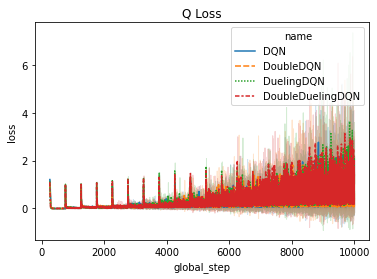

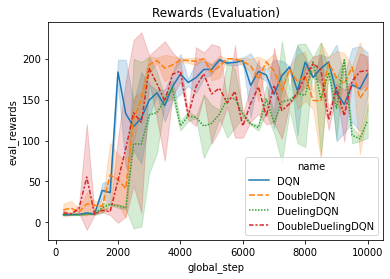

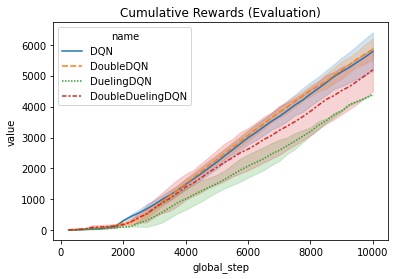

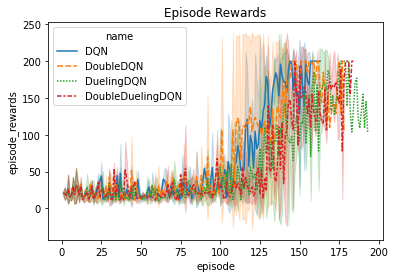

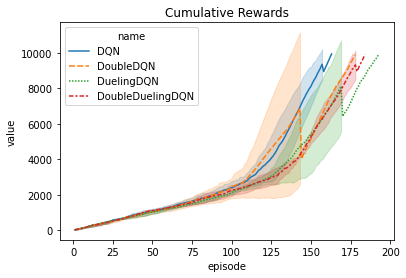

In [ ]:
all_dqn_managers = []
all_dqn_managers.append(dqn_manager)
all_dqn_managers.append(double_dqn_manager)
all_dqn_managers.append(dueling_dqn_manager)
all_dqn_managers.append(double_dueling_dqn_manager)

# We can plot the data that was 
# stored by the agent with self.writer.add_scalar(tag, value, global_step):
_ = plot_writer_data(all_dqn_managers, tag='loss', title='Q Loss')
_ = plot_writer_data(all_dqn_managers, tag='eval_rewards', title='Rewards (Evaluation)')
_ = plot_writer_data(all_dqn_managers, tag='eval_rewards', title='Cumulative Rewards (Evaluation)', preprocess_func=np.cumsum)

# rewards in each episode
# Warning: not all runs will have the same number of episodes. Can you see why?
_ = plot_writer_data(all_dqn_managers, tag='episode_rewards', xtag='episode', title='Episode Rewards')
_ = plot_writer_data(all_dqn_managers, tag='episode_rewards', xtag='episode', title='Cumulative Rewards', preprocess_func=np.cumsum)

# Part 2: REINFORCE



## Question 2.1 (written)

In class we have seen the derivation of the policy gradient theorem in the "Monte-Carlo style". Recall that the policy gradient is given by
$$
    \nabla_\theta J(\pi_\theta) = \mathbb{E}_{\tau \sim \mathbb{P}(\cdot|\pi_\theta)}\left[ \nabla_\theta \log \mathbb{P}(\tau|\pi_\theta) 
    R(\tau)
    \right]
$$
where $R(\tau) = \sum_{t=1}^{|\tau|} r_t$. By construction the policy gradient is on-policy, we need to estimate the gradient using the samples collected through the current policy $\pi_\theta$. 

1. *Derive an off-policy variant* by assuming to collect samples from a behavioral policy $\mu(s,a)$. The target policy, i.e., the policy for which we want to compute the gradient is $\pi_{\theta}$. Write explicitly the gradient log probability in your derivation.

2. What are the properties that $\mu$ needs to satisfy to obtain a meaningful gradient estimate?

**answer** 
1. Let $\tau$ be a trajectory.

$\tau = (s_0, a_0, r_0, s_1, ..., s_{\vert \tau \vert}, a_{\vert \tau \vert}, r_{\vert \tau \vert}, s_{\vert \tau \vert +1})$

$$
    \nabla_\theta J(\pi_\theta) = \mathbb{E}_{\tau \sim \mathbb{P}(\cdot|\pi_\theta)}\left[ \nabla_\theta \log \mathbb{P}(\tau|\pi_\theta) 
    R(\tau)
    \right] = \int \mathbb{P}(\tau|\pi_\theta)  \nabla_\theta \log \mathbb{P}(\tau|\pi_\theta) 
    R(\tau) \, d\tau = \int 
    \mathbb{P}(\tau|\mu) \dfrac{\mathbb{P}(\tau|\pi_\theta)}{\mathbb{P}(\tau|\mu)}  \nabla_\theta \log \mathbb{P}(\tau|\pi_\theta) 
    R(\tau) \, d\tau = \int 
    \mathbb{P}(\tau|\mu) \nabla_\theta \log \mathbb{P}(\tau|\pi_\theta) 
    R^{\mu}(\tau) \, d\tau 
$$

Finally, 

$$
    \boxed{\nabla_\theta J(\pi_\theta) = \mathbb{E}_{\tau \sim \mathbb{P}(\cdot|\mu)}\left[ \nabla_\theta \log \mathbb{P}(\tau|\pi_\theta)  R^{\mu}(\tau) \right]}
$$

with 
$$
  \mathbb{P}(\tau|\pi) = p(s_0) \times \pi(s_0,a_0) \times p(s_1 \vert s_0,a_0) \times ... \times \pi(s_{\vert \tau \vert},a_{\vert \tau \vert}) \times p(s_{\vert \tau \vert + 1} \vert s_{\vert \tau \vert},a_{\vert \tau \vert}) = K \times \prod_{i=1}^{\vert \tau \vert} \pi(s_i,a_i)
$$

$$
    R^{\mu}(\tau) = R(\tau). \prod_{i=1}^{\vert \tau \vert} \dfrac{\pi_\theta(s_i,a_i)}{\mu(s_i,a_i)}.
$$

$$ 
    \boxed{
    \nabla_\theta \log \mathbb{P}(\tau|\pi_\theta) = 
    \nabla_\theta \left[\log(K) + \log \left(\prod_{i=1}^{\vert \tau \vert} \pi_{\theta}(s_i,a_i)\right)\right] 
    = \sum_{i=1}^{\vert \tau \vert} \nabla_\theta \log (\pi_{\theta}(s_i,a_i))}
$$


2. The advantage is that the target policy may be deterministic (e.g., greedy), while the behaviorial policy can continue to sample all possible actions.Then, the exploration is easier with behaviorial policies. Here, it is a method of importance sampling and for this to work the distribution mass of $\mu$ must be close enough to that of $\pi_{\theta}$. One way to obtain a meaningful gradient estimate is to choose a behaviorial policy that behaves rather uniformly on the dataset. Moreover, we must require that every action taken under the current policy is also taken under the behaviorial policy. (i.e $\pi_{\theta}(s,a) > 0$ implies $\mu(s,a) > 0$). Finally, if we want a total exploration, we can require that the behaviorial policy is nonzero for all actions in all states.

## Question 2.2 (implementation)
Starting from the provided code, implement on-policy policy gradient
$$
    \nabla_\theta J(\pi_\theta) = \mathbb{E}_{\tau \sim \mathbb{P}(\cdot|\pi_\theta)}\left[ \nabla_\theta \log \mathbb{P}(\tau|\pi_\theta) 
    R(\tau)
    \right]
$$

Use the most efficient version of the gradient estimator without baseline (i.e., GPOMDP).

In [ ]:
class PolicyNet(nn.Module):
  def __init__(self, obs_size, n_actions):
    super(PolicyNet, self).__init__()
    self.fc1 = nn.Linear(obs_size, 64)
    self.ReLU = nn.ReLU()
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, n_actions)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, state):
    action_logits = self.ReLU(self.fc1(state))
    action_logits = self.ReLU(self.fc2(action_logits))
    action_logits = self.fc3(action_logits)
    # compute softmax of the output of the net, to get probabilities over actions
    action_probs = self.softmax(action_logits)
    dist = Categorical(action_probs)
    return action_logits, dist

In [ ]:
# Parameters
REINFORCE_TRAINING_TIMESTEPS = 5*DQN_TRAINING_TIMESTEPS  # number of timesteps for training. You might change this!

REINFORCE_PARAMS = dict(
    gamma=0.99,
    batch_size=200,            # batch size
    eval_every=250,            # evaluate every ... steps
    learning_rate=0.001,       # learning rate
)

In [ ]:
class REINFORCEAgent(Agent):
  name = 'REINFORCE'
  def __init__(
      self,
      env,
      gamma: float = 0.99,
      batch_size: int = 200,
      eval_every: int = 250,
      learning_rate: float = 0.1,
      **kwargs):
    Agent.__init__(self, env, **kwargs)
    env = self.env
    self.gamma = gamma
    self.batch_size = batch_size
    self.eval_every = eval_every
    self.total_timesteps = 0
    self.total_episodes = 0
    self.total_updates = 0
  
    # create network
    obs_size = env.observation_space.shape[0]
    n_actions = env.action_space.n
    self.policy_net = PolicyNet(obs_size, n_actions)

    # optimizer
    self.optimizer = optim.Adam(
        params=self.policy_net.parameters(), lr=learning_rate)

  def select_action(self, state, evaluation=False):
    """
    If evaluation=False, get action according to exploration policy.
    Otherwise, get action according to the evaluation policy.
    """
    tensor_state = torch.FloatTensor(state).to(device)
    with torch.no_grad():
      _, dist = self.policy_net(tensor_state)
      action = dist.sample().item()
    return action

  def fit(self, budget):
    """
    budget : number of training timesteps
    """
    state = self.env.reset()
    done = False
    episode_reward = 0.0

    trajectory_states = []
    trajectory_actions = []
    trajectory_rewards = []
    trajectory_dones = []

    for tt in range(budget):
      self.total_timesteps += 1
      action = self.select_action(state, evaluation=False)
      next_state, reward, done, _ = self.env.step(action)
      episode_reward += reward

      trajectory_states.append(state)
      trajectory_actions.append(action)
      trajectory_rewards.append(reward)
      trajectory_dones.append(done)

      if ((tt + 1) % self.batch_size) == 0:
        #
        # Update model
        #
        self.total_updates += 1

        # convert to torch tensors
        batch_state = torch.FloatTensor(
            np.array(trajectory_states, dtype=float)
            ).to(device)
        batch_action = torch.LongTensor(
             np.array(trajectory_actions, dtype=int)
             ).unsqueeze(1).to(device)
        batch_reward = torch.FloatTensor(
             np.array(trajectory_rewards, dtype=float)
            ).unsqueeze(1).to(device)
        batch_done = torch.FloatTensor(
            np.array(trajectory_dones, dtype=bool)
            ).unsqueeze(1).to(device)

        assert len(trajectory_actions) == self.batch_size

        action_logits, _ = self.policy_net(batch_state)
        logprobs = nn.functional.log_softmax(action_logits, dim=-1).gather(1, batch_action.long())
      
        #loss = torch.tensor(0.0)

        # Number of trajectories
        m = len(np.where(batch_done[:,0] == 1)[0]) + 1 

        # Instance of trajectories
        T = np.zeros(m) 
        T[:-1] = np.where(batch_done[:,0] == 1)[0]
        T = np.array(T, dtype = int)
        T[-1] = len(trajectory_actions) - 1
        test = np.zeros(m-1) 
        test = T[:-1]
        T[1:] = T[1:] - test
        q = torch.zeros(len(trajectory_actions))

        u = 0 # beginning of the new trajectory
        beg = 0 # variable for consistency 
        for i in range(m):
          for t in range(beg,T[i]+1):
            qit = torch.tensor([0.0])
            for k in range(t,T[i]+1): 
              qit += (self.gamma)**(k-t) * batch_reward[u+k]
            
            q[u+t] = qit
          
          u += T[i]
          beg = 1

        # Loss
        loss = torch.dot(logprobs.squeeze(),q)
        loss = -loss/m
      
      
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        
        # log info about loss
        self.writer.add_scalar('loss', loss.item(), self.total_timesteps)

        # clear data
        trajectory_states = []
        trajectory_actions = []
        trajectory_rewards = []
        trajectory_dones = []

      # evaluate agent
      if self.total_timesteps % self.eval_every == 0:
          mean_rewards = self.eval(n_sim=5)
          self.writer.add_scalar(
              'eval_rewards', mean_rewards, self.total_timesteps)

      # check end of episode
      state = next_state
      if done:
        state = self.env.reset()
        self.total_episodes += 1
        self.writer.add_scalar(
                'episode_rewards', episode_reward, self.total_timesteps)
        self.writer.add_scalar(
                'episode', self.total_episodes, self.total_timesteps)
        episode_reward = 0.0

  def eval(self, n_sim=1, **kwargs):
    rewards = np.zeros(n_sim)
    eval_env = self.eval_env     # evaluation environment
    # Loop over number of simulations
    for sim in range(n_sim):
      state = eval_env.reset()
      done = False
      while not done:
        action = self.select_action(state, evaluation=True)
        next_state, reward, done, _ = eval_env.step(action)
        # update sum of rewards
        rewards[sim] += reward
        state = next_state
    return rewards.mean()

In [ ]:
# # Training one instance of REINFORCE
# reinforce_agent = REINFORCEAgent(
#     env=(get_env, dict()),  # we can send (constructor, kwargs) as an env
#     **REINFORCE_PARAMS
# )
# reinforce_agent.fit(REINFORCE_TRAINING_TIMESTEPS)

#
# Training several instances using AgentManager
#
manager_kwargs = dict(
    agent_class=REINFORCEAgent,
    train_env=(get_env, dict()),
    eval_env=(get_env, dict()),
    fit_budget=REINFORCE_TRAINING_TIMESTEPS,
    n_fit=2,                # NOTE: You may increase this parameter (number of agents to train)
    parallelization='thread',
    seed=456,
    default_writer_kwargs=dict(maxlen=None,log_interval=10),
)

# REINFORCE
reinforce_manager = AgentManager(
    init_kwargs=REINFORCE_PARAMS,
    agent_name='REINFORCE',
    **manager_kwargs
)

# Train and append to previous managers
reinforce_manager.fit()

[WARNING] (Re)defining the following DefaultWriter parameters in AgentManager: ['maxlen', 'log_interval'] 
[INFO] Running AgentManager fit() for REINFORCE...  


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] [REINFORCE[worker: 0]] | max_global_step = 3400 | episode_rewards = 28.0 | dw_time_elapsed = 10.108323791999283 | episode = 136 | loss = 315.712890625 | eval_rewards = 27.0 |  
[INFO] [REINFORCE[worker: 1]] | max_global_step = 3400 | episode_rewards = 28.0 | dw_time_elapsed = 10.142523864000395 | episode = 138 | loss = 374.61651611328125 | eval_rewards = 24.4 |  
[INFO] [REINFORCE[worker: 0]] | max_global_step = 6400 | episode_rewards = 35.0 | dw_time_elapsed = 20.145402705999004 | episode = 235 | loss = 389.8067626953125 | eval_rewards = 48.2 |  
[INFO] [REINFORCE[worker: 1]] | max_global_step = 6552 | episode_rewards = 40.0 | dw_time_elapsed = 20.165951365001092 | episode = 242 | loss = 378.5142517089844 | eval_rewards = 45.6 |  
[INFO] [REINFORCE[worker: 0]] | max_global_step = 9165 | episode_rewards = 49.0 | dw_time_elapsed = 30.202932944001077 | episode = 304 | loss = 570.2207641601562 | eval_rewards = 35.2 |  
[INFO] [REINFORCE[worker: 1]] | max_global_step = 9200 | episod

INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


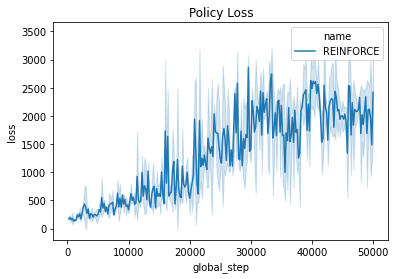

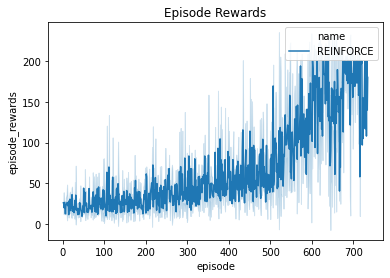

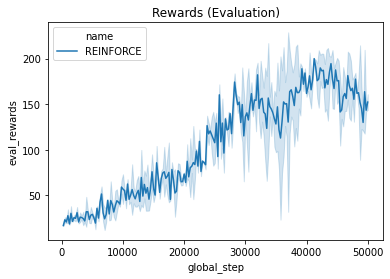

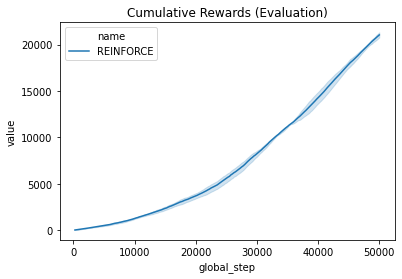

In [ ]:
 # Plots for REINFORCE
_ = plot_writer_data(reinforce_manager, tag='loss', title='Policy Loss')
_ = plot_writer_data(reinforce_manager, tag='episode_rewards', xtag='episode', title='Episode Rewards')
_ = plot_writer_data(reinforce_manager, tag='eval_rewards', title='Rewards (Evaluation)')
_ = plot_writer_data(reinforce_manager, tag='eval_rewards', title='Cumulative Rewards (Evaluation)', preprocess_func=np.cumsum)

#Part 3: Model Selection Using UCB

## Question 3.1: Model Selection for RL


In RL, it is hard to define in advance what is the best method to use and/or which architecture to choose for representing the policy or the value function.

Normally, several algorithms are run in parallel and the final performance is used to select the best algorithm. Can we do this online?

In this exercise, we present a simple idea for doing online model-selection by leveraging a multi-armed bandit (MAB) algorithm.

You will start from a list containing one instance of each agent that you trained above (different versions of DQN and REINFORCE), and you'll adaptively allocate computational resources to train those algorithms for more timesteps.

**Implement below the UCB algorithm such that, at reach round $t$:**    

* UCB selects the action $a_t$, which corresponds to one of the algorithms in the list;
* You train the algorithm for a few timesteps;
* UCB receives the reward $r_t$ which is equal to the Monte-Carlo policy evaluation of the chosen algorithm.

The goal of this strategy is to allocate more computational resources to the algorithms that are yielding more rewards.

In [ ]:
# Get one (pre-)trained agent from each manager
all_managers = all_dqn_managers + [reinforce_manager]
arms = [manager.get_agent_instances()[0] for manager in all_managers]
print(f"Arms/algorithms: {[alg.name for alg in arms]}")

# Select number of UCB rounds
UCB_N_ROUNDS = 200

# Number of training steps every time an agent is selected
N_STEPS_TO_TRAIN = 250

# Run UCB
all_episode_rewards = []
arm_counts = np.zeros(len(arms))
arm_cumulative_rewards = np.zeros(len(arms))
for tt in range(UCB_N_ROUNDS):
  if tt < len(arms):
    arm_index = tt
  else:
    rho = 1 
    mu = arm_cumulative_rewards/arm_counts
    # delta_t = 1/UCB_N_ROUNDS**2
    incertity = np.sqrt(rho*np.log(2*(UCB_N_ROUNDS)**2)/arm_counts)
    arm_index = np.argmax(mu + incertity)

  # train the selected algorithm for more timesteps
  arms[arm_index].fit(N_STEPS_TO_TRAIN)

  # evaluate arm
  episode_reward = arms[arm_index].eval()

  # update stats
  arm_counts[arm_index] += 1
  arm_cumulative_rewards[arm_index] += episode_reward

  # store reward
  all_episode_rewards.append(episode_reward)

  if (tt+1) % 10 == 0:
    print("-----------------------------------------------------------")
    print(f"UCB round {tt+1}, " 
          f"chosen algorithm: {arms[arm_index].name}, "
          f"eval reward = {episode_reward}.")
    print("-----------------------------------------------------------")

[INFO] [DQN[worker: 0]] | max_global_step = 10001 | episode_rewards = 200.0 | dw_time_elapsed = 713.8672757320019 | episode = 157 | eval_rewards = 162.8 | loss = 0.6984947919845581 |  


Arms/algorithms: ['DQN', 'DoubleDQN', 'DuelingDQN', 'DoubleDuelingDQN', 'REINFORCE']


[INFO] [DoubleDQN[worker: 0]] | max_global_step = 10001 | episode_rewards = 200.0 | dw_time_elapsed = 633.3535728380011 | episode = 143 | eval_rewards = 185.6 | loss = 1.145518183708191 |  
[INFO] [DuelingDQN[worker: 0]] | max_global_step = 10001 | episode_rewards = 180.0 | dw_time_elapsed = 548.0539080880008 | episode = 169 | eval_rewards = 109.4 | loss = 0.14489272236824036 |  
[INFO] [DoubleDuelingDQN[worker: 0]] | max_global_step = 10001 | episode_rewards = 200.0 | dw_time_elapsed = 446.7399542210005 | episode = 184 | eval_rewards = 197.6 | loss = 0.89137864112854 |  
[INFO] [REINFORCE[worker: 0]] | max_global_step = 50200 | episode_rewards = 200.0 | dw_time_elapsed = 333.4703581210015 | episode = 717 | loss = 3301.60693359375 | eval_rewards = 158.4 |  


-----------------------------------------------------------
UCB round 10, chosen algorithm: DQN, eval reward = 120.0.
-----------------------------------------------------------


[INFO] [DuelingDQN[worker: 0]] | max_global_step = 10501 | episode_rewards = 93.0 | dw_time_elapsed = 558.1310929370011 | episode = 172 | eval_rewards = 169.8 | loss = 0.42608171701431274 |  
[INFO] [REINFORCE[worker: 0]] | max_global_step = 51830 | episode_rewards = 80.0 | dw_time_elapsed = 344.0681776979982 | episode = 724 | loss = 3166.9462890625 | eval_rewards = 200.0 |  


-----------------------------------------------------------
UCB round 20, chosen algorithm: REINFORCE, eval reward = 200.0.
-----------------------------------------------------------
-----------------------------------------------------------
UCB round 30, chosen algorithm: REINFORCE, eval reward = 105.0.
-----------------------------------------------------------


[INFO] [DQN[worker: 0]] | max_global_step = 10751 | episode_rewards = 138.0 | dw_time_elapsed = 736.2928536670006 | episode = 160 | eval_rewards = 186.4 | loss = 0.44979944825172424 |  
[INFO] [DuelingDQN[worker: 0]] | max_global_step = 11251 | episode_rewards = 200.0 | dw_time_elapsed = 569.7320040630002 | episode = 175 | eval_rewards = 95.8 | loss = 0.26469895243644714 |  
[INFO] [REINFORCE[worker: 0]] | max_global_step = 55750 | episode_rewards = 125.0 | dw_time_elapsed = 354.0715435689999 | episode = 742 | loss = 2099.33544921875 | eval_rewards = 104.6 |  


-----------------------------------------------------------
UCB round 40, chosen algorithm: DQN, eval reward = 117.0.
-----------------------------------------------------------


[INFO] [DoubleDuelingDQN[worker: 0]] | max_global_step = 10501 | episode_rewards = 148.0 | dw_time_elapsed = 473.5675615750006 | episode = 186 | eval_rewards = 119.0 | loss = 0.7403354048728943 |  
[INFO] [REINFORCE[worker: 0]] | max_global_step = 57162 | episode_rewards = 162.0 | dw_time_elapsed = 364.7061153319992 | episode = 747 | loss = 2185.1005859375 | eval_rewards = 112.4 |  


-----------------------------------------------------------
UCB round 50, chosen algorithm: DoubleDuelingDQN, eval reward = 156.0.
-----------------------------------------------------------


[INFO] [DQN[worker: 0]] | max_global_step = 11751 | episode_rewards = 128.0 | dw_time_elapsed = 751.2720668500006 | episode = 165 | eval_rewards = 126.6 | loss = 0.16367612779140472 |  


-----------------------------------------------------------
UCB round 60, chosen algorithm: REINFORCE, eval reward = 140.0.
-----------------------------------------------------------


[INFO] [REINFORCE[worker: 0]] | max_global_step = 61200 | episode_rewards = 200.0 | dw_time_elapsed = 374.9579506689988 | episode = 763 | loss = 3106.5830078125 | eval_rewards = 167.6 |  


-----------------------------------------------------------
UCB round 70, chosen algorithm: REINFORCE, eval reward = 200.0.
-----------------------------------------------------------
-----------------------------------------------------------
UCB round 80, chosen algorithm: REINFORCE, eval reward = 200.0.
-----------------------------------------------------------


[INFO] [REINFORCE[worker: 0]] | max_global_step = 65250 | episode_rewards = 200.0 | dw_time_elapsed = 385.08535999000014 | episode = 780 | loss = 3057.778076171875 | eval_rewards = 179.0 |  


-----------------------------------------------------------
UCB round 90, chosen algorithm: REINFORCE, eval reward = 200.0.
-----------------------------------------------------------
-----------------------------------------------------------
UCB round 100, chosen algorithm: REINFORCE, eval reward = 200.0.
-----------------------------------------------------------


[INFO] [REINFORCE[worker: 0]] | max_global_step = 69500 | episode_rewards = 200.0 | dw_time_elapsed = 395.34748237700114 | episode = 797 | loss = 3231.193359375 | eval_rewards = 195.4 |  


-----------------------------------------------------------
UCB round 110, chosen algorithm: REINFORCE, eval reward = 200.0.
-----------------------------------------------------------


[INFO] [REINFORCE[worker: 0]] | max_global_step = 73750 | episode_rewards = 136.0 | dw_time_elapsed = 405.40724073800084 | episode = 814 | loss = 2157.69580078125 | eval_rewards = 198.6 |  


-----------------------------------------------------------
UCB round 120, chosen algorithm: REINFORCE, eval reward = 172.0.
-----------------------------------------------------------
-----------------------------------------------------------
UCB round 130, chosen algorithm: REINFORCE, eval reward = 200.0.
-----------------------------------------------------------


[INFO] [REINFORCE[worker: 0]] | max_global_step = 78950 | episode_rewards = 132.0 | dw_time_elapsed = 415.4119844199995 | episode = 842 | loss = 1403.0302734375 | eval_rewards = 110.2 |  


-----------------------------------------------------------
UCB round 140, chosen algorithm: REINFORCE, eval reward = 27.0.
-----------------------------------------------------------
-----------------------------------------------------------
UCB round 150, chosen algorithm: REINFORCE, eval reward = 147.0.
-----------------------------------------------------------


[INFO] [REINFORCE[worker: 0]] | max_global_step = 84000 | episode_rewards = 200.0 | dw_time_elapsed = 425.64944657199885 | episode = 868 | loss = 3112.1689453125 | eval_rewards = 198.4 |  


-----------------------------------------------------------
UCB round 160, chosen algorithm: REINFORCE, eval reward = 200.0.
-----------------------------------------------------------
-----------------------------------------------------------
UCB round 170, chosen algorithm: REINFORCE, eval reward = 141.0.
-----------------------------------------------------------
-----------------------------------------------------------
UCB round 180, chosen algorithm: REINFORCE, eval reward = 168.0.
-----------------------------------------------------------


[INFO] [REINFORCE[worker: 0]] | max_global_step = 89250 | episode_rewards = 150.0 | dw_time_elapsed = 435.7912479639999 | episode = 890 | loss = 2283.288330078125 | eval_rewards = 143.6 |  


-----------------------------------------------------------
UCB round 190, chosen algorithm: REINFORCE, eval reward = 200.0.
-----------------------------------------------------------


[INFO] [REINFORCE[worker: 0]] | max_global_step = 93669 | episode_rewards = 169.0 | dw_time_elapsed = 445.794071237 | episode = 907 | loss = 2879.853271484375 | eval_rewards = 196.4 |  


-----------------------------------------------------------
UCB round 200, chosen algorithm: REINFORCE, eval reward = 200.0.
-----------------------------------------------------------


Arms: ['DQN', 'DoubleDQN', 'DuelingDQN', 'DoubleDuelingDQN', 'REINFORCE']
Counts: [  8.   1.   7.   8. 176.]
Mean arm rewards: [153.375      145.         151.85714286 154.875      165.70454545]


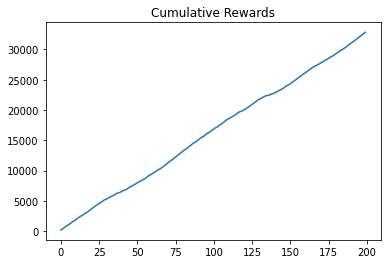

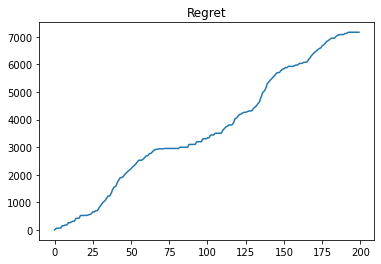

In [ ]:
# Print stats
print(f"Arms: {[alg.name for alg in arms]}")
print(f"Counts: {arm_counts}")
print(f"Mean arm rewards: {arm_cumulative_rewards/arm_counts}")

# Plot rewards and regret
all_episode_rewards = np.array(all_episode_rewards)
plt.figure()
plt.plot(np.cumsum(all_episode_rewards))
plt.title("Cumulative Rewards")
plt.figure()
plt.plot(np.cumsum(200.0 - all_episode_rewards))  # maximum reward in CartPole-v0 is 200.0
plt.title("Regret")
plt.show()

## Question 3.2: Is UCB well-suited for online model-selection?

At every round of UCB, one algorithm is selected and trained for a few timesteps. Does this break any assumption made by the UCB algorithm? If so, how would you handle this issue?


**answer**

It is possible to notice that the regret can be in $O(\sqrt{n\log(n)})$.
However, at some point only the REINFORCE algorithm is selected.

Because the problem begins without prior knowledge of rewards, it must explore and then exploit once it has narrowed its choices. Rather than performing exploration by simply selecting an arbitrary action, chosen with a probability that remains constant, the UCB algorithm changes its exploration-exploitation balance as it gains knowledge about the environment. It ceases to focus primarily on exploration, when actions that have been tried the least are preferred, and focuses on exploitation, selecting the action with the highest estimated reward. Thus, after training, the UCB will choose the algorithm and actions that give the best rewards based on the environment it knows and there will be no more exploration or uncertainty. One way to handle this problem is to bring more exploration into each round. For example, if we notice that an algorithm is chosen too often, we can decide not to choose an algorithm by maximization but rather randomly to rebalance. We can also consider random uncertainty bounds as in Thompson sampling.

# REFERENCES 
[1] Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.

[2] https://towardsdatascience.com/the-upper-confidence-bound-ucb-bandit-algorithm-c05c2bf4c13f